In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
img = cv2.imread('img001.jpg')

# 輪郭抽出(台形の4頂点を検出する)

In [3]:
#画像の2値化
def binalizeByAdaptive(img):
    r = img.copy()

    # R, G値のみ取り出しグレースケール化
    green = r[:,:,1]
    red = r[:,:,2]
    redGreen = cv2.fastNlMeansDenoisingColored(r,None,10,10,7,21)
    redGreen = cv2.addWeighted(red, 0.5, green, 0.5, 0)  
    # binalize
    th_red = cv2.adaptiveThreshold(redGreen,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,7,1)
    
    # cleaning noise by opening
    kernel = np.ones((1,1),np.uint8)
    th_red = cv2.morphologyEx(th_red, cv2.MORPH_OPEN, kernel)

    # cv2.waitKey(0)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.imshow(th_red)
    plt.show()

    return th_red

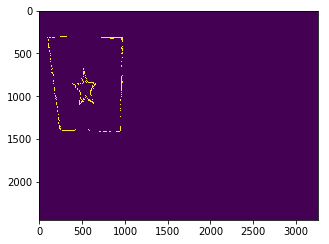

In [4]:
th_red=binalizeByAdaptive(img)

In [5]:
#輪郭の検出
image, contours, hierarchy = cv2.findContours(th_red,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

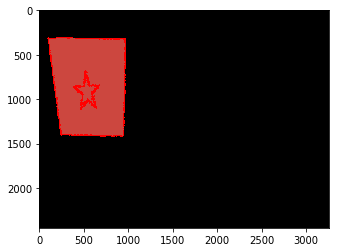

In [6]:
#検出した輪郭の描画
img_co = cv2.drawContours(img.copy(), contours, -1, (255,0,0), 3)
plt.imshow(img_co)

In [7]:
size = img.shape[0] * img.shape[1]
tmp_img=image.copy()
max_area = 0
approxs = []

# 入力座標の選定
best_white = 0
best_rate = 0.0
best_approx = []
dict_approx = {}

for cnt in contours:
    area = cv2.contourArea(cnt)
    epsilon = 0.1 * cv2.arcLength(cnt, True)
    hull = cv2.convexHull(cnt)
    # 面積が1%以上、99%未満
    if size * 0.01 <= area and area <= size * 0.99 and max_area < area:
        best_approx = hull
        max_area = area
        #四角形で輪郭を近似する
        rect = cv2.minAreaRect(hull)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

if 0 != max_area:
    print('Success!')
else:
    print('Failed')

Success!


In [8]:
def draw_contours(ax, img, cnt):
    ax.imshow(img.copy())
    ax.axis('off')
    cnt = np.squeeze(cnt, axis=1)  # (NumPoints, 1, 2) -> (NumPoints, 2)
    # 輪郭の点同士を結ぶ線を描画する。
    ax.add_patch(Polygon(cnt, color='b', fill=None, lw=2))
    # 輪郭の点を描画する。
    ax.plot(cnt[:, 0], cnt[:, 1], 'ro', mew=0, ms=4)

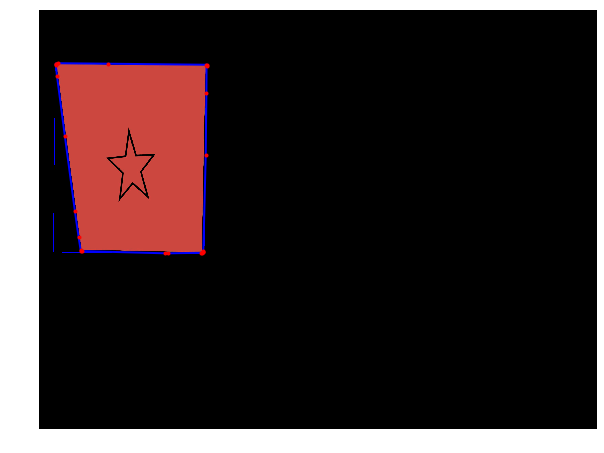

In [9]:
imtest = cv2.drawContours(img.copy(),[box.astype(int)],0,(0,0,255),2)
fig, ax = plt.subplots(figsize=(10, 10))
draw_contours(ax, imtest, best_approx)
plt.show()

In [10]:
#後の計算のためにデータ構造を変更
shape=best_approx.shape
_best_approx=best_approx.reshape(shape[0],shape[2])

In [11]:
#元画像の4頂点（四隅）を求める
imcorners=np.array([[0,0],[img.shape[0],0],[0,img.shape[1]],[img.shape[0],img.shape[1]]])
imcorners.shape

(4, 2)

In [12]:
#検出した輪郭の頂点と元画像の四隅の距離を計算
all_diffs = np.expand_dims(_best_approx, axis=1) - np.expand_dims(imcorners, axis=0)
distance = np.sqrt(np.sum(all_diffs ** 2, axis=-1)).astype(np.int32)

In [13]:
#検出した輪郭の中で元画像の四隅とそれぞれ最も距離が近い点を物体にの4頂点とする
index_min=distance.argmin(axis=0)
ltop=_best_approx[index_min[0]]
rtop=_best_approx[index_min[1]]
lbottom=_best_approx[index_min[2]]
rbottom=_best_approx[index_min[3]]

# 検出した台形の射影変換

In [14]:
#画像の横と縦の長さを切り出す
rows,cols,ch = img.shape

# 画像の座標上から4角を切り出す
# pts1 = np.float32([[左上の座標],[右上の座標],[左下の座標],[右下の座標]])
pts1 = np.float32([ltop,rtop,lbottom,rbottom])
pts2 = np.float32([[0,0],[cols,0],[0,rows],[cols,rows]])

# 透視変換の行列を求める
M = cv2.getPerspectiveTransform(pts1,pts2)
rst = cv2.warpPerspective(img,M,(cols,rows))


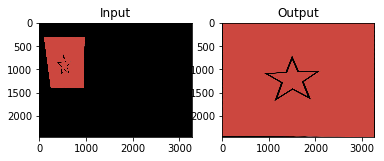

In [15]:
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(rst),plt.title('Output')
plt.show()

## 元に戻してみる

In [16]:
# 透視変換の行列の逆行列を求める(
M_=np.linalg.inv(M) 
rst_ = cv2.warpPerspective(rst,M_,(cols,rows))

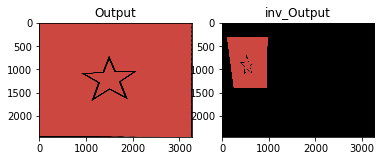

In [17]:
plt.subplot(121),plt.imshow(rst),plt.title('Output')
plt.subplot(122),plt.imshow(rst_),plt.title('inv_Output')
plt.show()

## 射影変換後の画像で検出された四角形の４頂点の元画像における座標を調べる

In [18]:
#同じサイズの画像を用意
obj = np.zeros(rst.shape, dtype = np.uint8)
#以下のように頂点の座標が求められたとする
tlx = 1  
tly = 1 
brx = 100 
bry = 100 
#オブジェクトの範囲を白(0<)にする
obj[tlx:brx+1,tly:bry+1]=[255,255,255]

In [19]:
#透視変換行列の逆行列をかけて元の画像に変換する
obj_ = cv2.warpPerspective(obj,M_,(cols,rows))

In [20]:
#値が0以上となる最小、最大の座標(index)をもとめる
indices = np.dstack(np.where(obj_ >0))
x_min=indices[0][0][0]
y_min=indices[0][0][1]
x_max=indices[0][-1][0]
y_max=indices[0][-1][1]